In [100]:
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras

from sklearn.model_selection import train_test_split
from google.colab import files

time: 804 µs (started: 2024-08-30 00:33:03 +00:00)


In [51]:
!pip install ipython-autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [52]:
%load_ext autotime

time: 286 µs (started: 2024-08-29 22:51:19 +00:00)


# Model Train

In [15]:
model_dice = pkl.load(open('/content/model_pre_compiled.pkl', 'rb'))
model_iou = pkl.load(open('/content/model_pre_compiled.pkl', 'rb'))
model_tversky = pkl.load(open('/content/model_pre_compiled.pkl', 'rb'))
x = pkl.load(open('/content/x.pkl', 'rb'))
y = pkl.load(open('/content/y_face.pkl', 'rb'))[:len(x)]

In [101]:
"""
Source: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
"""

@keras.saving.register_keras_serializable()
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.

    Also known as the intersection-over-union loss.

    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.

    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?

    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.

    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.

    # Returns
        The Jaccard distance between the two tensors.

    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)

    """
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=-1)
    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

time: 865 µs (started: 2024-08-30 00:33:09 +00:00)


In [62]:
model_dice.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.losses.dice,
    metrics=['accuracy', 'precision', 'recall'],
)

model_iou.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=jaccard_distance,
    metrics=['accuracy', 'precision', 'recall'],
)

model_tversky.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    loss=tf.losses.tversky,
    metrics=['accuracy', 'precision', 'recall'],
)

checkpointer_dice = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/segmentacao_dice.keras',
    verbose=1,
    save_best_only=True,
    mode="auto",
    monitor="loss"
)

checkpointer_iou = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/segmentacao_iou.keras',
    verbose=1,
    save_best_only=True,
    mode="auto",
    monitor="loss"
)

checkpointer_tversky = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/segmentacao_tversky.keras',
    verbose=1,
    save_best_only=True,
    mode="auto",
    monitor="loss"
)

time: 19.1 ms (started: 2024-08-29 23:07:12 +00:00)


In [27]:
model_dice.summary(), model_iou.summary(), model_tversky.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 18,450,115 (70.38 MB)

 Trainable params: 18,447,235 (70.37 MB)

 Non-trainable params: 2,880 (11.25 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 18,450,115 (70.38 MB)

 Trainable params: 18,447,235 (70.37 MB)

 Non-trainable params: 2,880 (11.25 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 18,450,115 (70.38 MB)

 Trainable params: 18,447,235 (70.37 MB)

 Non-trainable params: 2,880 (11.25 KB)

(None, None, None)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

time: 186 ms (started: 2024-08-29 23:06:10 +00:00)


In [63]:
tf.config.run_functions_eagerly(True)
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  H_dice = model_dice.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[checkpointer_dice],
    shuffle=True,
    validation_data=(x_test, y_test)
)

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5918 - loss: -0.9666 - precision: 0.4635 - recall: 0.9935
Epoch 1: loss improved from inf to -0.96790, saving model to /content/segmentacao_dice.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 769ms/step - accuracy: 0.5917 - loss: -0.9666 - precision: 0.4635 - recall: 0.9935 - val_accuracy: 0.6862 - val_loss: -0.9703 - val_precision: 0.4569 - val_recall: 0.9942
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.5740 - loss: -0.9712 - precision: 0.4494 - recall: 0.9954
Epoch 2: loss improved from -0.96790 to -0.97188, saving model to /content/segmentacao_dice.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 776ms/step - accuracy: 0.5741 - loss: -0.9712 - precision: 0.4494 - recall: 0.9954 - val_accuracy: 0.6531 - val_loss: -0.9704 - val_precision: 0.4582 - val_recall: 0.9938
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5752 - loss: -0.9741 - precision: 0.4438 - recall: 0.9966
Epoch 3: loss improved from -0.97

In [72]:
tf.config.run_functions_eagerly(True)
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  H_iou = model_iou.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[checkpointer_iou],
    shuffle=True,
    validation_data=(x_test, y_test)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.2813 - loss: -36.9596 - precision: 0.4296 - recall: 0.6968
Epoch 1: loss improved from inf to -82.87290, saving model to /content/segmentacao_iou.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 768ms/step - accuracy: 0.2822 - loss: -37.4281 - precision: 0.4298 - recall: 0.6975 - val_accuracy: 0.8326 - val_loss: -186.5010 - val_precision: 0.4660 - val_recall: 0.8363
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.4469 - loss: -199.9959 - precision: 0.4997 - recall: 0.8770
Epoch 2: loss improved from -82.87290 to -218.37134, saving model to /content/segmentacao_iou.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 771ms/step - accuracy: 0.4471 - loss: -200.1834 - precision: 0.5000 - recall: 0.8772 - val_accuracy: 0.7994 - val_loss: -259.7464 - val_precision: 0.4433 - val_recall: 0.9665
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.4519 - loss: -251.9377 - precision: 0.5623 - recall: 0.9439
Epoch 3: loss impro

In [74]:
tf.config.run_functions_eagerly(True)
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  H_tversky = model_tversky.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[checkpointer_tversky],
    shuffle=True,
    validation_data=(x_test, y_test)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.3174 - loss: -0.2300 - precision: 0.4343 - recall: 0.7544
Epoch 1: loss improved from inf to -0.40637, saving model to /content/segmentacao_tversky.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 707ms/step - accuracy: 0.3190 - loss: -0.2318 - precision: 0.4345 - recall: 0.7553 - val_accuracy: 0.3757 - val_loss: -0.0863 - val_precision: 0.5162 - val_recall: 0.8019
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5771 - loss: -0.7196 - precision: 0.4707 - recall: 0.9292
Epoch 2: loss improved from -0.40637 to -0.77187, saving model to /content/segmentacao_tversky.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 86s 756ms/step - accuracy: 0.5768 - loss: -0.7202 - precision: 0.4708 - recall: 0.9293 - val_accuracy: 0.1716 - val_loss: -0.6752 - val_precision: 0.4871 - val_recall: 0.9549
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5609 - loss: -0.8704 - precision: 0.5075 - recall: 0.9674
Epoch 3: loss improved from

In [80]:
pkl.dump(H_dice.history, open('h_dice.pkl', 'wb'))

time: 753 µs (started: 2024-08-30 00:21:18 +00:00)


# Prediction Testing

In [103]:
x = pkl.load(open('/content/x.pkl', 'rb'))
y = pkl.load(open('/content/y_face.pkl', 'rb'))[:len(x)]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

model_dice = tf.keras.models.load_model('/content/segmentacao_dice.keras')
model_iou = tf.keras.models.load_model('/content/segmentacao_iou.keras')
model_tversky = tf.keras.models.load_model('/content/segmentacao_tversky.keras')

time: 1min 5s (started: 2024-08-30 00:34:12 +00:00)


In [115]:
def plot_predictions(models, img):
  """
  Use plt to plot predictions to the same image from mutiple model
  Parameters:
    models: list of tf models
    img: tuple of images (x, y)
  """
  def predict(model, im):
    """
    Model expects differnt array size from image, function to load image as is
    """
    pred = pred = model.predict(np.expand_dims(im, axis=0))
    return np.squeeze(pred)

  _, axs = plt.subplots(1, len(models) + 2, figsize=(16, 4))
  axs[0].imshow(img[0])
  axs[0].set_title('X')
  axs[0].axis('off')
  for i, ax in enumerate(axs[1:]):
    ax.imshow(predict(models[i - 1], img[0]))
    ax.set_title(f'Model {i}')
    ax.axis('off')
  axs[-1].imshow(img[1])
  axs[-1].set_title('Ground Truth')
  axs[-1].axis('off')
  plt.tight_layout()
  plt.show()

time: 1.32 ms (started: 2024-08-30 00:48:08 +00:00)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


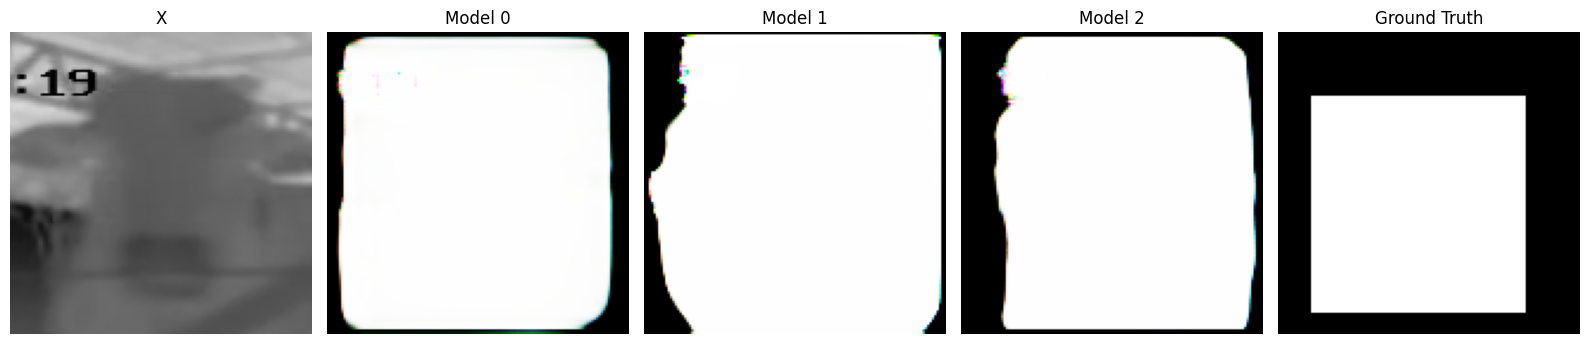

time: 1.15 s (started: 2024-08-30 00:48:10 +00:00)


In [116]:
plot_predictions((model_dice, model_iou, model_tversky), (x_test[700], y_test[700]))

# DataViz


In [117]:
h_dice = pkl.load(open('/content/h_dice.pkl', 'rb'))
h_iou = pkl.load(open('/content/h_iou.pkl', 'rb'))
h_tversky = pkl.load(open('/content/h_tversky.pkl', 'rb'))

time: 1.98 ms (started: 2024-08-30 00:50:39 +00:00)


In [118]:
def plot_from_history(h):
  """
  Use plt to plot tf history
  """
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(h['accuracy'], label='Training Accuracy')
  if 'val_accuracy' in h:
      plt.plot(h['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(h['loss'], label='Training Loss')
  if 'val_loss' in h:
      plt.plot(h['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

time: 1.01 ms (started: 2024-08-30 00:50:48 +00:00)


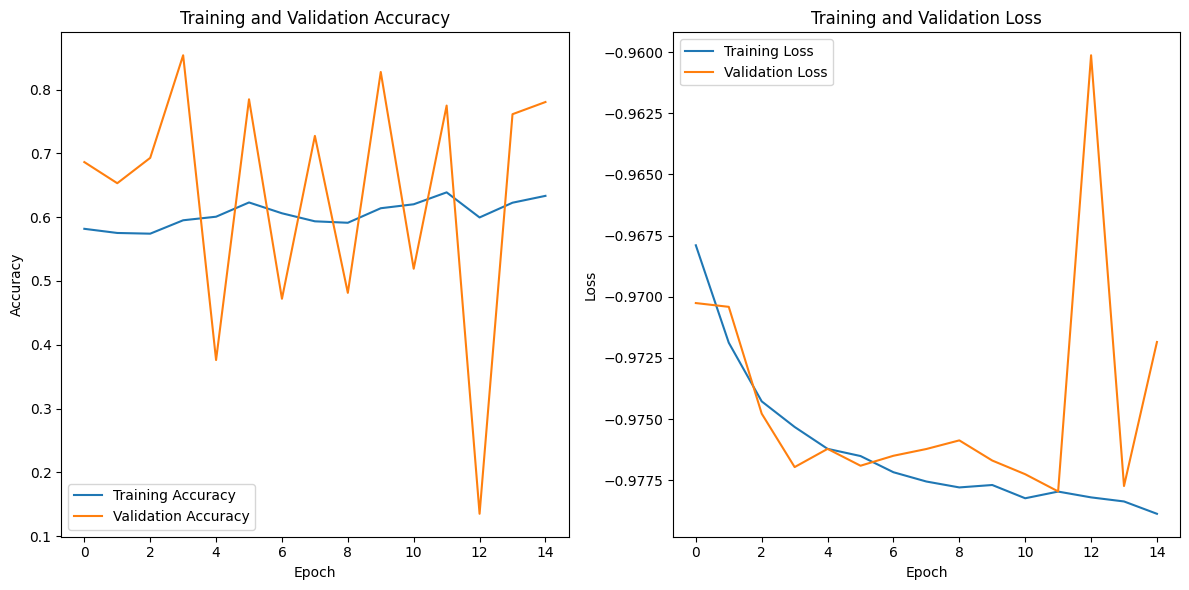

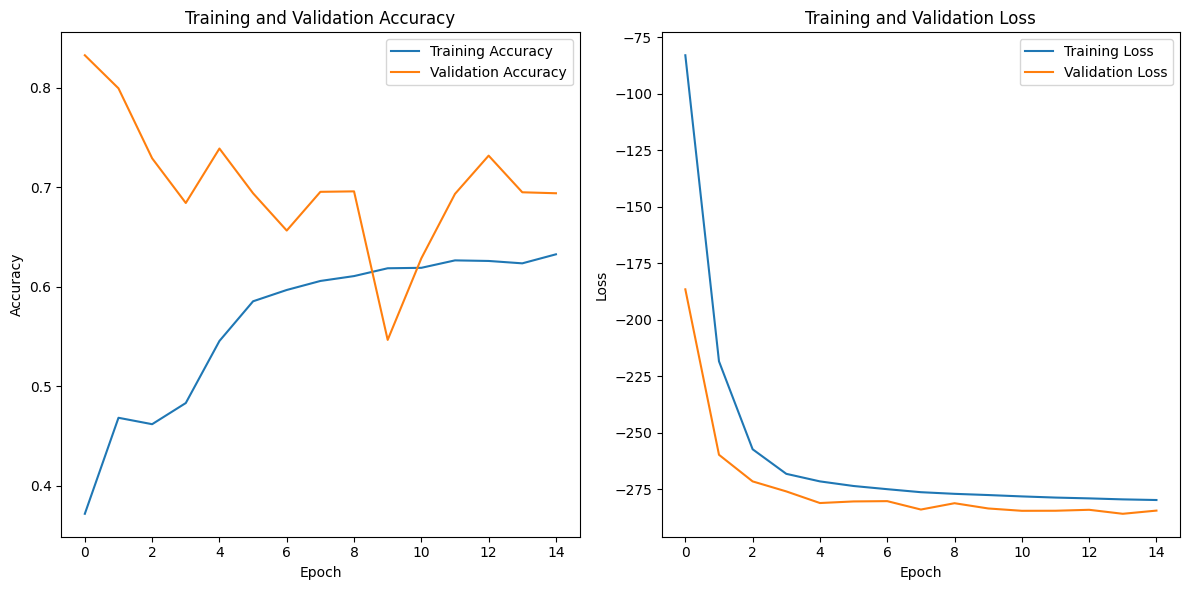

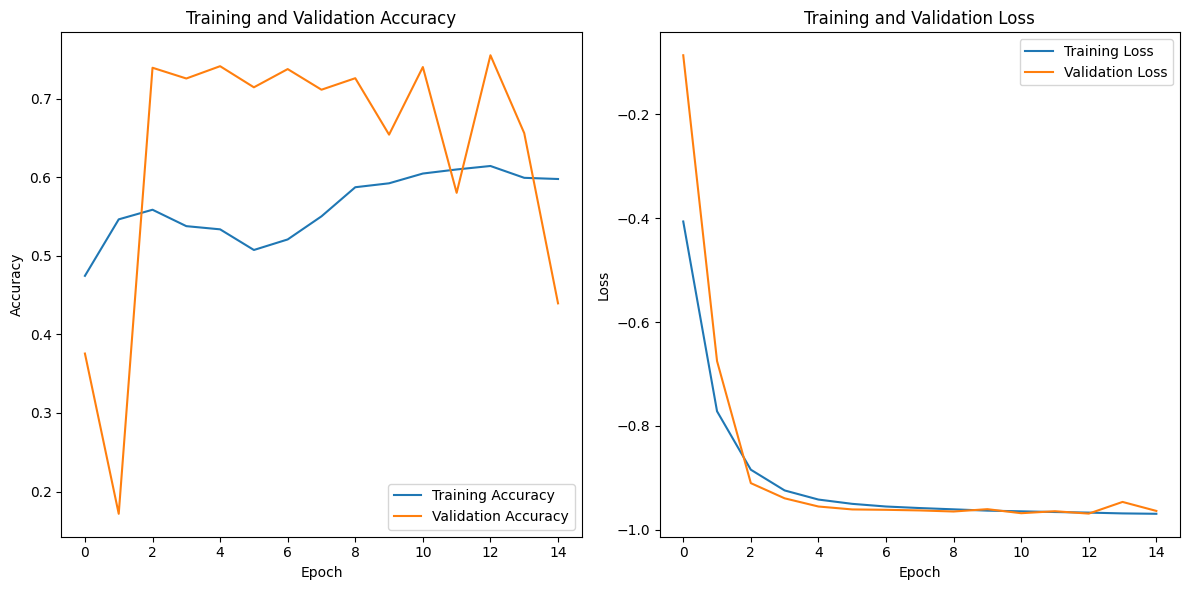

time: 1.87 s (started: 2024-08-30 00:51:50 +00:00)


In [122]:
plot_from_history(h_dice)
print()
plot_from_history(h_iou)
print()
plot_from_history(h_tversky)